In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

### 해야 하는 것
- 진주 소재에 제조업들의 주 생산품이 무엇인 지 확인이 필요함.
- 실제 생산품이 무엇인 지 확인해야 하기 때문에 '생산품' 칼럼에 대해 데이터 전처리를 해야함.
- 예를 들어, 농기계부품, 농기계 부품이 띄어쓰기 하나로 다른 생산품으로 인식하고 있음.

# 1. 전처리

In [5]:
# 01. 데이터 불러오기
df = pd.read_csv('경상남도 진주시_제조업_20250831.csv', encoding='cp949')
df.head()

,순번,단지명,회사명,공장대표주소(도로명),공장대표주소(지번),업종번호,업종명,업종분류,전화번호,팩스번호,남종업원,여종업원,외국인(남),외국인(여),종업원수,생산품,용지면적,제조시설면적,부대시설면적,건축면적
0,1,진주상평일반산업단지,디와이이엔지,"경상남도 진주시 동진로 290(상대동, 호림철강)",경상남도 진주시 상대동 33-87 호림철강,"30320,",자동차 차체용 신품 부품 제조업,"자동차, 운송장비",055-761-8172,공람,4,6,0,0,10,자동차 부품,877.8,811.80,66.00,877.80
1,2,진주상평일반산업단지,(유)동양프라스틱,경상남도 진주시 동진로264번길 12 (상대동) 외 1필지,경상남도 진주시 상대2동 313-2번지 외 1필지,"22232,",포장용 플라스틱 성형용기 제조업,"석유화학, 플라스틱",055-762-4588,055-757-1438,8,5,0,0,13,육묘상자,1858.2,645.41,0.00,645.41
2,3,진주상평일반산업단지,(유)유창이엔지,경상남도 진주시 돗골로58번길 19 (상평동),경상남도 진주시 상평동 201-4번지,"29210,",농업 및 임업용 기계 제조업,"금속가공, 기계",055-753-9396,055-753-1036,3,1,0,0,4,농기계부품,1322.3,629.00,171.64,800.64
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,15,5,0,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98
4,5,진주상평일반산업단지,(주)경남레이저산업,경상남도 진주시 공단로236번길 19-1 (상평동),경상남도 진주시 상평동 55-80,"25929,",그 외 기타 금속가공업,"금속가공, 기계",055-752-9902,공람,10,2,8,0,20,전동기부품,1636.0,1238.40,0.00,1238.40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   순번           1294 non-null   int64  
 1   단지명          1294 non-null   object 
 2   회사명          1294 non-null   object 
 3   공장대표주소(도로명)  1294 non-null   object 
 4   공장대표주소(지번)   1294 non-null   object 
 5   업종번호         1294 non-null   object 
 6   업종명          1294 non-null   object 
 7   업종분류         1294 non-null   object 
 8   전화번호         1294 non-null   object 
 9   팩스번호         1294 non-null   object 
 10  남종업원         1294 non-null   int64  
 11  여종업원         1294 non-null   int64  
 12  외국인(남)       1294 non-null   int64  
 13  외국인(여)       1294 non-null   int64  
 14  종업원수         1294 non-null   int64  
 15  생산품          1294 non-null   object 
 16  용지면적         1294 non-null   float64
 17  제조시설면적       1294 non-null   float64
 18  부대시설면적       1294 non-null   float64
 19  건축면적  

In [7]:
# 02. '생산품' 칼럼 유니크 값 확인
df['생산품'].nunique() # 데이터 값이 총 1,294개 인데, 유니크한 값이 1,032개임. --> 중복을 삭제해야 함.

1032

In [8]:
df['업종분류'].nunique() # 업종분류의 경우는 잘 나뉘어져 있음. 다만, 실제 기업의 생산품을 확인해야 하기 때문에 생산품 칼럼에 대해 전처리를 진행.

10

In [9]:
df['생산품'].value_counts()

생산품
농기계부품            50
자동차부품            39
중장비부품            13
자동차 부품           12
농기구부품             8
                 ..
가래떡               1
닭고기 부위별 분할 포장     1
치과기공물             1
환자복제조             1
전동기부품             1
Name: count, Length: 1032, dtype: int64

In [10]:
# 콤마 쪼개고 (split), 행 늘리기 (explode)
df1 = df.copy()
df1 = df1.assign(생산품_분리=df1['생산품'].str.split(',')).explode('생산품_분리')

df1.head()

,순번,단지명,회사명,공장대표주소(도로명),공장대표주소(지번),업종번호,업종명,업종분류,전화번호,팩스번호,...,여종업원,외국인(남),외국인(여),종업원수,생산품,용지면적,제조시설면적,부대시설면적,건축면적,생산품_분리
0,1,진주상평일반산업단지,디와이이엔지,"경상남도 진주시 동진로 290(상대동, 호림철강)",경상남도 진주시 상대동 33-87 호림철강,"30320,",자동차 차체용 신품 부품 제조업,"자동차, 운송장비",055-761-8172,공람,...,6,0,0,10,자동차 부품,877.8,811.80,66.00,877.80,자동차 부품
1,2,진주상평일반산업단지,(유)동양프라스틱,경상남도 진주시 동진로264번길 12 (상대동) 외 1필지,경상남도 진주시 상대2동 313-2번지 외 1필지,"22232,",포장용 플라스틱 성형용기 제조업,"석유화학, 플라스틱",055-762-4588,055-757-1438,...,5,0,0,13,육묘상자,1858.2,645.41,0.00,645.41,육묘상자
2,3,진주상평일반산업단지,(유)유창이엔지,경상남도 진주시 돗골로58번길 19 (상평동),경상남도 진주시 상평동 201-4번지,"29210,",농업 및 임업용 기계 제조업,"금속가공, 기계",055-753-9396,055-753-1036,...,1,0,0,4,농기계부품,1322.3,629.00,171.64,800.64,농기계부품
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,5,0,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,수전금구
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,5,0,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,가공타일 등


In [11]:
df1.info() # 분리된 만큼 행의 개수가 늘어난 것임.

<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 0 to 1293
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   순번           2166 non-null   int64  
 1   단지명          2166 non-null   object 
 2   회사명          2166 non-null   object 
 3   공장대표주소(도로명)  2166 non-null   object 
 4   공장대표주소(지번)   2166 non-null   object 
 5   업종번호         2166 non-null   object 
 6   업종명          2166 non-null   object 
 7   업종분류         2166 non-null   object 
 8   전화번호         2166 non-null   object 
 9   팩스번호         2166 non-null   object 
 10  남종업원         2166 non-null   int64  
 11  여종업원         2166 non-null   int64  
 12  외국인(남)       2166 non-null   int64  
 13  외국인(여)       2166 non-null   int64  
 14  종업원수         2166 non-null   int64  
 15  생산품          2166 non-null   object 
 16  용지면적         2166 non-null   float64
 17  제조시설면적       2166 non-null   float64
 18  부대시설면적       2166 non-null   float64
 19  건축면적       

In [12]:
# 괄호와 공백 제거
# 함수 사용
df2 = df1.copy()

def clean_text(text):
    if not isinstance(text, str): return "" # 문자가 아니면 패스
    # 1. 괄호와 그 안의 내용 제거 (농기계(트랙터) --> 농기계로 통합)
    text = re.sub(r'\(.*?\)', '', text)
    
    # 2. 특수문자 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9]', '', text)

    # 3. 띄어씌기 제거
    return text.replace(' ', '')

# 함수 적용
df2['생산품_전처리'] = df2['생산품_분리'].apply(clean_text)

df2.head()

,순번,단지명,회사명,공장대표주소(도로명),공장대표주소(지번),업종번호,업종명,업종분류,전화번호,팩스번호,...,외국인(남),외국인(여),종업원수,생산품,용지면적,제조시설면적,부대시설면적,건축면적,생산품_분리,생산품_전처리
0,1,진주상평일반산업단지,디와이이엔지,"경상남도 진주시 동진로 290(상대동, 호림철강)",경상남도 진주시 상대동 33-87 호림철강,"30320,",자동차 차체용 신품 부품 제조업,"자동차, 운송장비",055-761-8172,공람,...,0,0,10,자동차 부품,877.8,811.80,66.00,877.80,자동차 부품,자동차부품
1,2,진주상평일반산업단지,(유)동양프라스틱,경상남도 진주시 동진로264번길 12 (상대동) 외 1필지,경상남도 진주시 상대2동 313-2번지 외 1필지,"22232,",포장용 플라스틱 성형용기 제조업,"석유화학, 플라스틱",055-762-4588,055-757-1438,...,0,0,13,육묘상자,1858.2,645.41,0.00,645.41,육묘상자,육묘상자
2,3,진주상평일반산업단지,(유)유창이엔지,경상남도 진주시 돗골로58번길 19 (상평동),경상남도 진주시 상평동 201-4번지,"29210,",농업 및 임업용 기계 제조업,"금속가공, 기계",055-753-9396,055-753-1036,...,0,0,4,농기계부품,1322.3,629.00,171.64,800.64,농기계부품,농기계부품
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,수전금구,수전금구
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,가공타일 등,가공타일등


In [33]:
df2.head(50)

,순번,단지명,회사명,공장대표주소(도로명),공장대표주소(지번),업종번호,업종명,업종분류,전화번호,팩스번호,...,외국인(남),외국인(여),종업원수,생산품,용지면적,제조시설면적,부대시설면적,건축면적,생산품_분리,생산품_전처리
0,1,진주상평일반산업단지,디와이이엔지,"경상남도 진주시 동진로 290(상대동, 호림철강)",경상남도 진주시 상대동 33-87 호림철강,"30320,",자동차 차체용 신품 부품 제조업,"자동차, 운송장비",055-761-8172,공람,...,0,0,10,자동차 부품,877.80,811.80,66.00,877.80,자동차 부품,자동차부품
1,2,진주상평일반산업단지,(유)동양프라스틱,경상남도 진주시 동진로264번길 12 (상대동) 외 1필지,경상남도 진주시 상대2동 313-2번지 외 1필지,"22232,",포장용 플라스틱 성형용기 제조업,"석유화학, 플라스틱",055-762-4588,055-757-1438,...,0,0,13,육묘상자,1858.20,645.41,0.00,645.41,육묘상자,육묘상자
2,3,진주상평일반산업단지,(유)유창이엔지,경상남도 진주시 돗골로58번길 19 (상평동),경상남도 진주시 상평동 201-4번지,"29210,",농업 및 임업용 기계 제조업,"금속가공, 기계",055-753-9396,055-753-1036,...,0,0,4,농기계부품,1322.30,629.00,171.64,800.64,농기계부품,농기계부품
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,0,20,"수전금구, 가공타일 등",15724.00,7180.98,1779.00,8959.98,수전금구,수전금구
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,0,20,"수전금구, 가공타일 등",15724.00,7180.98,1779.00,8959.98,가공타일 등,가공타일등
4,5,진주상평일반산업단지,(주)경남레이저산업,경상남도 진주시 공단로236번길 19-1 (상평동),경상남도 진주시 상평동 55-80,"25929,",그 외 기타 금속가공업,"금속가공, 기계",055-752-9902,공람,...,8,0,20,전동기부품,1636.00,1238.40,0.00,1238.40,전동기부품,전동기부품
5,6,진주상평일반산업단지,(주)경남철공,경상남도 진주시 공단로 80 (상평동),경상남도 진주시 상평동 222-10번지,"25112,",구조용 금속 판제품 및 공작물 제조업,"금속가공, 기계",055-752-3205,055-758-3205,...,0,0,8,철구조물,1818.20,242.00,22.00,264.00,철구조물,철구조물
6,7,진주상평일반산업단지,(주)경서,경상남도 진주시 공단로 237 (상평동),경상남도 진주시 상평동 55-50번지,"13300,",편조원단 제조업,"섬유, 의복",055-752-2527,055-753-3060,...,0,0,22,환자복제조,3275.00,652.53,414.84,1067.37,환자복제조,환자복제조
7,8,진주상평일반산업단지,(주)경일파츠테크,경상남도 진주시 동진로 326 (상대동),경상남도 진주시 상대동 33-141번지,"30400, 30202",자동차 재제조 부품 제조업 외 1 종,"자동차, 운송장비",15222118,공람,...,0,0,6,"재제조부품, 제작차",0.00,812.50,0.00,812.50,재제조부품,재제조부품
7,8,진주상평일반산업단지,(주)경일파츠테크,경상남도 진주시 동진로 326 (상대동),경상남도 진주시 상대동 33-141번지,"30400, 30202",자동차 재제조 부품 제조업 외 1 종,"자동차, 운송장비",15222118,공람,...,0,0,6,"재제조부품, 제작차",0.00,812.50,0.00,812.50,제작차,제작차


In [28]:
# 진주시 산업 특성 크게 8개로 분류할 예정
# 1. 농기계/농자재
# 2. 항공/우주/방산
# 3. 자동차/운송장비
# 4. 중장비/건설기계
# 5. 실크/섬유/의류
# 6. 식품 가공
# 7. 금속/건자재/구조물
# 8. 전기/전자/IT
# 9. 기타 제조업

array(['자동차, 운송장비', '석유화학, 플라스틱', '금속가공, 기계', '비금속', '섬유, 의복', '전기, 전자',
       '목재, 종이, 출판', '기타', '1차금속, 철강', '음식료'], dtype=object)

In [68]:
# 산업군 그룹핑
# 함수 생성
def categorize_product(text):
    # 1. 농기계/농자재/비료/사료
    if any(x in text for x in ['농기', '트랙터', '경운기', '이앙기', '콤바인', '육묘', '비료', '농약', '사료', 
                               '양식', '축산', '스마트팜', '재배', '호미', '낫', '예취기', '살포기', '건조기', '정미기', '상토']):
        return '농기계/농자재'
    
    # 2. 항공/우주/방산
    elif any(x in text for x in ['항공', '드론', '방산', '비행', '우주', '무기', '총포', '시뮬레이터', '위성', '발사체', '탄피']):
        return '항공/우주/방산'
        
    # 3. 자동차/운송장비 (용어 확장: 밋숀, 오일팬, 캠핑카 등)
    elif any(x in text for x in ['자동차', '차량', '승용', '버스', '트럭', '엔진', '변속기', '조향', '브레이크', '타이어', 
                                 '선박', '조선', '보트', '카누', '카약', '미션', '밋숀', '오일팬', '디프', '차체', '시트', 
                                 '배터리', '전지', '캠핑카', '트레일러', '휠', '라디에이터', '와이퍼', '범퍼', '자전거', '이륜']):
        return '자동차/운송장비'

    # 4. 중장비/건설기계
    elif any(x in text for x in ['중장비', '굴삭기', '건설기계', '지게차', '유압', '크레인', '버켓', '투스', '롤러', '브레이커']):
        return '중장비/건설기계'
        
    # 5. 실크/섬유/의류/침구
    elif any(x in text for x in ['실크', '한복', '견직', '섬유', '직물', '의류', '커튼', '넥타이', '자수', '방적', '제직', '이불', 
                                 '침구', '양말', '원단', '염색', '가공사', '복', '셔츠', '정장', '패션', '마스크', '부직포', '양장']):
        return '실크/섬유/의류'
    
    # 6. 식품/가공/바이오 (바이오, 효소, 각종 식품 추가)
    elif any(x in text for x in ['식품', '떡', '차', '즙', '육', '소스', '김치', '빵', '면', '버섯', '농산물', '음료', '커피', '가공', '반찬', 
                                 '식초', '두부', '참기름', '들기름', '장', '주', '술', '조림', '액', '환', '분말', '죽', '빙과', '얼음', 
                                 '효소', '유산균', '바이오', '추출물', '엑기스', '건강', '제과', '제빵', '통조림', '수산물', '건어물']):
        return '식품/가공'

    # 7. 금속/기계/건자재 (가장 범위가 넓음 - 현장용어 대거 추가)
    elif any(x in text for x in [
        # 금속/부품
        '금속', '철물', '도금', '주물', '강관', '탱크', '철판', '절단', '용접', '나사', '볼트', '너트', '와이어', '메쉬', '스프링', '베어링',
        '기어', '샤프트', '밸브', '축', '금형', '가공', '부품', '모터', '펌프', '브라켓', '플랜지', '프랜지', '후랜지', '조인트', '피팅', 
        '실린더', '피스톤', '노즐', '핀', '부싱', '롤', '치공구', '공구', '기계',
        # 건자재/구조물
        '창호', '샤시', '샷시', '구조물', '울타리', '관', '파이프', '레미콘', '아스콘', '콘크리트', '타일', '벽돌', '블록', '기와', 
        '단열', '방수', '유리', '도어', '문', '난간', '데크', '판넬', '패널', '닥트', '후드', '배관', '수전', '금구', '싱크', '씽크',
        '그레이팅', '맨홀', '스틸', '알루미늄', '스테인리스', '스텐', '철재', '열처리', '연마', '도장', '코팅'
    ]):
        return '금속/기계/건자재'

    # 8. 전기/전자/IT
    elif any(x in text for x in ['CCTV', 'LED', '방송', '통신', '전광판', '제어', '배전', '소프트웨어', '시스템', '센서', '계측', 
                                 '반도체', '디스플레이', '모듈', '회로', '스위치', '개폐기', '변압기', '발전기', '카메라', '영상', '음향', 
                                 '스피커', '앰프', '3D프린터', '로봇', '드론', '광학', '레이저']):
        return '전기/전자/IT'
    
    # 9. 생활/가구/인쇄/화학
    elif any(x in text for x in [
        # 가구/생활
        '가구', '소파', '쇼파', '의자', '책상', '장', '목재', '파렛트', '팔레트',
        # 인쇄/포장
        '인쇄', '출판', '간판', '광고', '현수막', '종이', '박스', '상자', '포장', '용기', '스티커', '명함', '지', # 지(박엽지 등)
        # 화학/가스
        '화학', '플라스틱', '고무', '비닐', '스티로폼', '화장품', '비누', '세제', '샴푸', '가스', '산소', '수소', '질소', '약품', '의약', '치약'
    ]):
        return '생활/가구/인쇄/화학'

    else:
        return '기타 제조업'

In [69]:
df3 = df2.copy()
df3['카테고리'] = df3['생산품_전처리'].apply(categorize_product)
df3.head()

,순번,단지명,회사명,공장대표주소(도로명),공장대표주소(지번),업종번호,업종명,업종분류,전화번호,팩스번호,...,외국인(여),종업원수,생산품,용지면적,제조시설면적,부대시설면적,건축면적,생산품_분리,생산품_전처리,카테고리
0,1,진주상평일반산업단지,디와이이엔지,"경상남도 진주시 동진로 290(상대동, 호림철강)",경상남도 진주시 상대동 33-87 호림철강,"30320,",자동차 차체용 신품 부품 제조업,"자동차, 운송장비",055-761-8172,공람,...,0,10,자동차 부품,877.8,811.80,66.00,877.80,자동차 부품,자동차부품,자동차/운송장비
1,2,진주상평일반산업단지,(유)동양프라스틱,경상남도 진주시 동진로264번길 12 (상대동) 외 1필지,경상남도 진주시 상대2동 313-2번지 외 1필지,"22232,",포장용 플라스틱 성형용기 제조업,"석유화학, 플라스틱",055-762-4588,055-757-1438,...,0,13,육묘상자,1858.2,645.41,0.00,645.41,육묘상자,육묘상자,농기계/농자재
2,3,진주상평일반산업단지,(유)유창이엔지,경상남도 진주시 돗골로58번길 19 (상평동),경상남도 진주시 상평동 201-4번지,"29210,",농업 및 임업용 기계 제조업,"금속가공, 기계",055-753-9396,055-753-1036,...,0,4,농기계부품,1322.3,629.00,171.64,800.64,농기계부품,농기계부품,농기계/농자재
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,수전금구,수전금구,금속/기계/건자재
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,가공타일 등,가공타일등,식품/가공


In [70]:
df3['카테고리'].value_counts()

카테고리
금속/기계/건자재      486
기타 제조업         401
식품/가공          324
농기계/농자재        235
자동차/운송장비       227
생활/가구/인쇄/화학    123
중장비/건설기계       109
전기/전자/IT       101
실크/섬유/의류        85
항공/우주/방산        75
Name: count, dtype: int64

In [71]:
# 기타 제조업으로 분류된 항목들
df3[df3['카테고리'] == '기타 제조업']['생산품_전처리'].value_counts().head()

생산품_전처리
각재        6
조형물       5
도막형바닥재    4
조명타워      4
카바        4
Name: count, dtype: int64

In [72]:
# 회사 기준으로 다시 합치기 (농기계/농자재 + 자동차/운송장비)
# 회사 카테고리 중복 없이 리스트로 모으기
company_categories = df3.groupby(level=0)['카테고리'].unique()
company_categories

0                  [자동차/운송장비]
1                   [농기계/농자재]
2                   [농기계/농자재]
3          [금속/기계/건자재, 식품/가공]
4                 [금속/기계/건자재]
                ...          
1289          [식품/가공, 기타 제조업]
1290    [생활/가구/인쇄/화학, 기타 제조업]
1291                  [식품/가공]
1292                  [식품/가공]
1293               [자동차/운송장비]
Name: 카테고리, Length: 1294, dtype: object

In [73]:
df3['최종_생산품'] = company_categories.apply(lambda x: ' + '.join(sorted(x)))

df3['최종_생산품'].value_counts()

최종_생산품
금속/기계/건자재                        279
식품/가공                            180
기타 제조업                           164
농기계/농자재                          149
자동차/운송장비                         117
                                ... 
농기계/농자재 + 실크/섬유/의류 + 자동차/운송장비      3
생활/가구/인쇄/화학 + 자동차/운송장비             2
농기계/농자재 + 항공/우주/방산                 2
생활/가구/인쇄/화학 + 항공/우주/방산             2
자동차/운송장비 + 전기/전자/IT                2
Name: count, Length: 84, dtype: int64

In [74]:
df4 = df.copy()
df4['최종_생산품'] = company_categories.apply(lambda x: ' + '.join(sorted(x)))

df4['최종_생산품'].value_counts()

최종_생산품
금속/기계/건자재                                      221
농기계/농자재                                        141
식품/가공                                          132
기타 제조업                                         120
자동차/운송장비                                       115
                                              ... 
기타 제조업 + 식품/가공 + 자동차/운송장비 + 전기/전자/IT             1
자동차/운송장비 + 전기/전자/IT                              1
금속/기계/건자재 + 기타 제조업 + 생활/가구/인쇄/화학 + 실크/섬유/의류      1
금속/기계/건자재 + 기타 제조업 + 중장비/건설기계 + 항공/우주/방산         1
금속/기계/건자재 + 기타 제조업 + 생활/가구/인쇄/화학 + 전기/전자/IT      1
Name: count, Length: 84, dtype: int64

In [75]:
# 기타 제조업에서 가장 많이 등장하는 단어
df3[df3['카테고리'] == '기타 제조업']['생산품_전처리'].value_counts().head(30)

생산품_전처리
각재            6
조형물           5
도막형바닥재        4
조명타워          4
카바            4
통합배선반         3
건물번호판         3
케이스           3
보행매트          3
판재            3
SHAFT         2
도시락           2
해충퇴치기         2
팬코일           2
4RCOVER       2
비디오           2
권양기           2
보리            2
쌀             2
명찰            2
곡물선식          2
노방            2
RFID음식물종량기    2
백미            2
현미            2
응용SW          2
철근커플러         2
분전반           2
인견            2
사프트           2
Name: count, dtype: int64

In [13]:
# 카테고리 분류 함수 확장
df3 = df2.copy()
# 산업군 그룹핑
# 함수 생성
def categorize_product(text):
    if not isinstance(text, str):
        return '기타 제조업'
    
    # 분석을 위해 잠시 대문자로 변환
    text_upper = text.upper()

    # 1. 농기계/농자재
    if any(x in text for x in ['농기', '트랙터', '경운기', '이앙기', '콤바인', '육묘', '비료', '농약', '사료', 
                               '양식', '축산', '스마트팜', '재배', '호미', '낫', '예취기', '살포기', '건조기', '정미기', 
                               '상토', '농업', '수경', '방제', '퇴치', '포충', '온실', '하우스', '부직포', 
                               '화분', '펠렛', '조청', '곡물', '선식', '꿀', '응애', '탄저', '배양', '제제', '땅속작물']):
        return '농기계/농자재'
        
    # 2. 항공/우주/방산 
    elif any(x in text for x in ['항공', '드론', '방산', '비행', '우주', '무기', '총포', '시뮬레이터', '위성', '발사체', 
                                 '탄피', '총탄', '헬리콥터', '방위', '프로펠러', '무인']):
        return '항공/우주/방산'
    
    # 3. 자동차/운송장비
    elif any(x in text_upper for x in ['자동차', '차량', '승용', '버스', '트럭', '엔진', '변속기', '조향', '브레이크', 
                                 '타이어', '튜브', '선박', '조선', '보트', '카누', '카약', '미션', '밋숀', '오일팬', '디프', 
                                 '차체', '시트', '배터리', '전지', '캠핑카', '트레일러', '휠', '라디에이터', '와이퍼', '범퍼', 
                                 '자전거', '이륜', '밧데리', '릴레이', '인젝터', '수상', '레저', '스쿠터', '히치', '드로우바', 
                                 'AUTOTEV', '4RCOVER', '언더그릴', '커플러', '조인트', 'JOINT', '연접봉', '하우징',
                                 'ARM', '암', '밋션', '캐리어', '덤프']):
        return '자동차/운송장비'
        
    # 4. 중장비/건설기계
    elif any(x in text_upper for x in ['중장비', '굴삭기', '건설기계', '지게차', '유압', '크레인', '버켓', '투스', '롤러', '브레이커', 
                                 '무한궤도', '트랙', 'TRACK', 'LINK', '링크', '호이스트', '권양기', '집진기', '시험기', '사출기',
                                 '바인더', '감속기', '완충기']):
        return '중장비/건설기계'

    # 5. 실크/섬유/의류/침구
    elif any(x in text for x in ['실크', '한복', '견직', '섬유', '직물', '의류', '커튼', '넥타이', '자수', '방적', '제직', '이불', 
                                 '침구', '양말', '원단', '염색', '가공사', '복', '셔츠', '정장', '패션', '마스크', '부직포', '양장', 
                                 '화섬', '인견', '노방', '마대', '포대', '보호대', '가방', '모자', '휘장', '블라인드', '브라인드', '신발',
                                 '연사', '막', '카페트', '매트', '직조', '블라인더', '어구']):
        return '실크/섬유/의류'
    
    # 6. 식품/바이오/의약
    elif any(x in text_upper for x in ['식품', '떡', '차', '즙', '육', '소스', '김치', '빵', '면', '버섯', '농산물', '음료', '커피', 
                               '가공', '반찬', '식초', '두부', '참기름', '들기름', '장', '주', '술', '조림', '액', '환', '분말', 
                               '죽', '빙과', '얼음', '효소', '유산균', '바이오', '추출물', '엑기스', '건강', '제과', '제빵', 
                               '통조림', '수산', '건어', '포', '구이', '과자', '맥아', '소금', '정제', '곰탕', '잼', '캔디', 
                               '항체', '진단', '키트', '시약', '배지', '균', '소독', '약품', '의약', '치약', '비누', '세제', '샴푸', '화장품', 
                               '요구르트', '나물', '멸치', '무침', '국수', '도시락', '한과', '호두과자', '쥐치', '오징어', '치과', '기공물', 
                               '칫솔', '물티슈', '고기', '닭', '오리', '돈', '우', '미', '쌀', '보리', '곡', '마늘', '양파', '채소', 
                               '황칠', '새싹', '젤리', '미네랄', '글루코사민', '레진', '토마토', '뽕잎', '어묵', 
                               '밀가루', '국', '벼', '도정', 'SOY', '콩', 'VEGUT', '아쿠아킹']):
        return '식품/바이오/의약'
    # 7. 금속/기계/건자재
    elif any(x in text_upper for x in [
        '금속', '철물', '도금', '주물', '강관', '탱크', '철판', '절단', '용접', '나사', '볼트', '너트', '와이어', '메쉬', '스프링', '베어링',
        '기어', '샤프트', '밸브', '축', '금형', '가공', '부품', '모터', '전동기', '펌프', '브라켓', '플랜지', '프랜지', '후랜지', 'PLANGE',
        '조인트', '피팅', '실린더', '피스톤', '노즐', '핀', '부싱', 'BUSH', '롤', 'ROLL', '치공구', '공구', '기계', 
        'SHAFT', 'SHART', '사프트', 'BLOCK', '블럭', 'HUB', '허브', 'CAM', '캠', '카바', '커버', '케이스', 'CASE', '스크류', '컨베이어',
        '탭', '드릴', '선반', '금구', '건조대', '파레트랙', '소방자재', '오거', '만능', '절곡', '성형', '커플러', '케이싱', '소음기',
        '에어콘', '팬코일', '플러그', '저울', '분동', '제거기', '세척기', '레바', '레버', '스텝', 'PITTING', '연결구', '쟁기', '형볼', '콘넥트',
        '단조', '철탑', '플랜트', '시제품', '모형', '수도', '계량기', '챔버', '마스터', '빔', '부재', '조형물',
        # 건자재/조경/시설물/목재
        '창호', '샤시', '샷시', '구조물', '울타리', '관', '파이프', '레미콘', '아스콘', '콘크리트', '타일', '벽돌', '기와', 
        '단열', '방수', '유리', '도어', '문', '난간', '데크', '판넬', '패널', '닥트', '후드', '배관', '수전', '금구', '싱크', '씽크',
        '그레이팅', '맨홀', '스틸', '알루미늄', '스테인리스', '스텐', '철재', '열처리', '연마', '도장', '코팅', '컨테이너',
        '방부목', '각재', '판재', '목재', '석재', '경계석', '표지판', '신호등', '가로등', '조명', '시설물', '전봇대', '파일', '앵글', '볼라드',
        '가드레일', '도로안전', '우편함', '부스', '벤치', '퍼걸러', '테이블', '철강', '필름', '랩', '망태', '보호판', '골재', '석', '판', 
        '아크릴', '창', '모래', '형강', '봉강', '바닥재', '인조석', '도자', '식기', '톱밥', '목', '시그멘트'
    ]):
        return '금속/기계/건자재'

    # 8. 전기/전자/IT/SW
    elif any(x in text_upper for x in ['CCTV', 'LED', '방송', '통신', '전광판', '제어', '배전', '분전반', '소프트웨어', 'SW', '시스템', 
                                       '센서', '계측', '반도체', '디스플레이', '모듈', '회로', '스위치', '개폐기', '변압기', '발전기', 
                                       '카메라', '영상', '음향', '스피커', '앰프', '3D', '로봇', '드론', '광학', '레이저', 
                                       '컴퓨터', '서버', '접속함', '전기', '전자', '배선', '정수기', '공기청정기', '경보기', '단말기', 
                                       '투광등', '측정', '원격', '강우량계', 'RFID', 'PCB', 'BIT', 'QR', '스크린', '보드', '송수신', 
                                       '미터링', '저장', '기억', '중계기', '교통신호', '프로젝', '화이트보드', '안내판', '번호판', '표찰',
                                       '케이블', '하네스', '비디오', 'VIDEO', '스트라이크', '설비조작']):
        return '전기/전자/IT'
    
    # 9. 생활/가구/인쇄/화학
    elif any(x in text for x in [
        '가구', '소파', '쇼파', '의자', '책상', '장', '파렛트', '팔레트', '돗자리', '매트', '골프', '캔오프너', '빨래집게', '에코딱',
        '인쇄', '출판', '간판', '광고', '현수막', '종이', '박스', '상자', '포장', '용기', '스티커', '명함', '명찰', '마크', '지', '리플렛', '카탈로그',
        '화학', '플라스틱', '고무', '비닐', '스티로폼', '가스', '산소', '수소', '질소', '아세칠렌', '충전', 'LPG', 'CMB', '고체',
        '염소', '투입기', '탈취', '응집', '여과', '연수', '미생물', '왁스', '세라믹', '소재'
    ]):
        return '생활/가구/인쇄/화학'

    else:
        return '기타 제조업'

In [14]:
df3['카테고리'] = df3['생산품_전처리'].apply(categorize_product)
df3.head()

,순번,단지명,회사명,공장대표주소(도로명),공장대표주소(지번),업종번호,업종명,업종분류,전화번호,팩스번호,...,외국인(여),종업원수,생산품,용지면적,제조시설면적,부대시설면적,건축면적,생산품_분리,생산품_전처리,카테고리
0,1,진주상평일반산업단지,디와이이엔지,"경상남도 진주시 동진로 290(상대동, 호림철강)",경상남도 진주시 상대동 33-87 호림철강,"30320,",자동차 차체용 신품 부품 제조업,"자동차, 운송장비",055-761-8172,공람,...,0,10,자동차 부품,877.8,811.80,66.00,877.80,자동차 부품,자동차부품,자동차/운송장비
1,2,진주상평일반산업단지,(유)동양프라스틱,경상남도 진주시 동진로264번길 12 (상대동) 외 1필지,경상남도 진주시 상대2동 313-2번지 외 1필지,"22232,",포장용 플라스틱 성형용기 제조업,"석유화학, 플라스틱",055-762-4588,055-757-1438,...,0,13,육묘상자,1858.2,645.41,0.00,645.41,육묘상자,육묘상자,농기계/농자재
2,3,진주상평일반산업단지,(유)유창이엔지,경상남도 진주시 돗골로58번길 19 (상평동),경상남도 진주시 상평동 201-4번지,"29210,",농업 및 임업용 기계 제조업,"금속가공, 기계",055-753-9396,055-753-1036,...,0,4,농기계부품,1322.3,629.00,171.64,800.64,농기계부품,농기계부품,농기계/농자재
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,수전금구,수전금구,금속/기계/건자재
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,가공타일 등,가공타일등,식품/바이오/의약


In [15]:
# 기타 카테고리가 하나라도 있는데, 기타 제조업이 섞여있으면 기타를 삭제
def simple_cat(category_list):
    # 중복 제거
    unique_cats = set(category_list)

    if len(unique_cats) > 1 and '기타 제조업' in unique_cats:
        unique_cats.remove('기타 제조업')

    # 리스트를 문자열로 변환
    return ' + '.join(sorted(unique_cats))

In [16]:
# 회사 별로 다시 묶기
df4 = df.copy()
company_categories = df3.groupby(level=0)['카테고리'].unique()
df4['최종 생산품'] = company_categories.apply(simple_cat)
df4['최종 생산품'] = df4['최종 생산품'].fillna('기타/미분류')

df4.value_counts().reset_index()

,순번,단지명,회사명,공장대표주소(도로명),공장대표주소(지번),업종번호,업종명,업종분류,전화번호,팩스번호,...,외국인(남),외국인(여),종업원수,생산품,용지면적,제조시설면적,부대시설면적,건축면적,최종 생산품,count
0,1,진주상평일반산업단지,디와이이엔지,"경상남도 진주시 동진로 290(상대동, 호림철강)",경상남도 진주시 상대동 33-87 호림철강,"30320,",자동차 차체용 신품 부품 제조업,"자동차, 운송장비",055-761-8172,공람,...,0,0,10,자동차 부품,877.8,811.80,66.00,877.80,자동차/운송장비,1
1,2,진주상평일반산업단지,(유)동양프라스틱,경상남도 진주시 동진로264번길 12 (상대동) 외 1필지,경상남도 진주시 상대2동 313-2번지 외 1필지,"22232,",포장용 플라스틱 성형용기 제조업,"석유화학, 플라스틱",055-762-4588,055-757-1438,...,0,0,13,육묘상자,1858.2,645.41,0.00,645.41,농기계/농자재,1
2,3,진주상평일반산업단지,(유)유창이엔지,경상남도 진주시 돗골로58번길 19 (상평동),경상남도 진주시 상평동 201-4번지,"29210,",농업 및 임업용 기계 제조업,"금속가공, 기계",055-753-9396,055-753-1036,...,0,0,4,농기계부품,1322.3,629.00,171.64,800.64,농기계/농자재,1
3,4,진주상평일반산업단지,(유)화신테크,경상남도 진주시 남강로 1273 (상평동),경상남도 진주시 상평동 55-39번지,"23222, 23232",위생용 및 산업용 도자기 제조업 외 1 종,비금속,055-755-6811,055-755-2288,...,0,0,20,"수전금구, 가공타일 등",15724.0,7180.98,1779.00,8959.98,금속/기계/건자재 + 식품/바이오/의약,1
4,5,진주상평일반산업단지,(주)경남레이저산업,경상남도 진주시 공단로236번길 19-1 (상평동),경상남도 진주시 상평동 55-80,"25929,",그 외 기타 금속가공업,"금속가공, 기계",055-752-9902,공람,...,8,0,20,전동기부품,1636.0,1238.40,0.00,1238.40,금속/기계/건자재,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,1290,개별입지,효은철강,경상남도 진주시 진성면 동부로 1448 (진성면 동산리 109-3 제2종근린생활시설...,경상남도 진주시 진성면 동산리 109-3번지 진성면 동산리 109-3 제2종근린생활...,"25999, 25995",그 외 기타 분류 안된 금속 가공 제품 제조업 외 1 종,"금속가공, 기계",055-742-7747,공람,...,0,0,5,"농산물운반대, 건조대,파레트랙",573.0,45.44,48.72,94.16,금속/기계/건자재 + 식품/바이오/의약 + 중장비/건설기계,1
1290,1291,개별입지,휴림디자인,경상남도 진주시 문산읍 소문길17번길 7-14,경상남도 진주시 문산읍 소문리 220-1,"25932, 32029, 32091",일반철물 제조업 외 2 종,"금속가공, 기계",ARS-1599-9579,055-754-0119,...,0,0,3,"흔들의자, 옥외벤치, 옥외테이블, 가드레일발판",0.0,167.50,0.00,167.50,금속/기계/건자재 + 생활/가구/인쇄/화학,1
1291,1292,개별입지,휴먼바이오텍(주),"경상남도 진주시 문산읍 월아산로 991, 성장지원동 307호 (진주바이오산업진흥원)",경상남도 진주시 문산읍 삼곡리 1033번지 진주바이오산업진흥원 성장지원동 307호,"21102,",생물학적 제제 제조업,"석유화학, 플라스틱",055-763-6127,055-763-6131,...,0,0,4,화장품,0.0,132.00,66.00,198.00,식품/바이오/의약,1
1292,1293,개별입지,흥진ENG,경상남도 진주시 남강로1179번길 10-4 (상평동),경상남도 진주시 상평동 302-4번지,"29294,",주형 및 금형 제조업,"금속가공, 기계",055-752-8614,055-753-6009,...,0,0,4,주형(금형),264.1,189.47,80.59,270.06,식품/바이오/의약,1


In [17]:
df4['최종 생산품'].value_counts().reset_index()

,최종 생산품,count
0,금속/기계/건자재,302
1,식품/바이오/의약,181
2,농기계/농자재,161
3,자동차/운송장비,126
4,중장비/건설기계,70
...,...,...
58,금속/기계/건자재 + 실크/섬유/의류 + 자동차/운송장비,1
59,식품/바이오/의약 + 자동차/운송장비 + 전기/전자/IT + 항공/우주/방산,1
60,전기/전자/IT + 항공/우주/방산,1
61,생활/가구/인쇄/화학 + 실크/섬유/의류,1


In [18]:
list(df3[df3['카테고리'] == '기타 제조업']['생산품_전처리'].unique())

['기타외',
 '부서',
 '고정캡',
 '칼날',
 '볼죠인트',
 '안전부착물',
 '저류조',
 '치구등',
 'CX',
 'DCI',
 'CTP',
 '테크제',
 '',
 '캐비닛외',
 '항',
 '표준품',
 '정비']

In [19]:
df3[df3['카테고리'] == '기타 제조업']['생산품_전처리'].nunique()

17

# 2. 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_21440\1144904768.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, y='생산품 분류', x='기업수', palette='viridis')


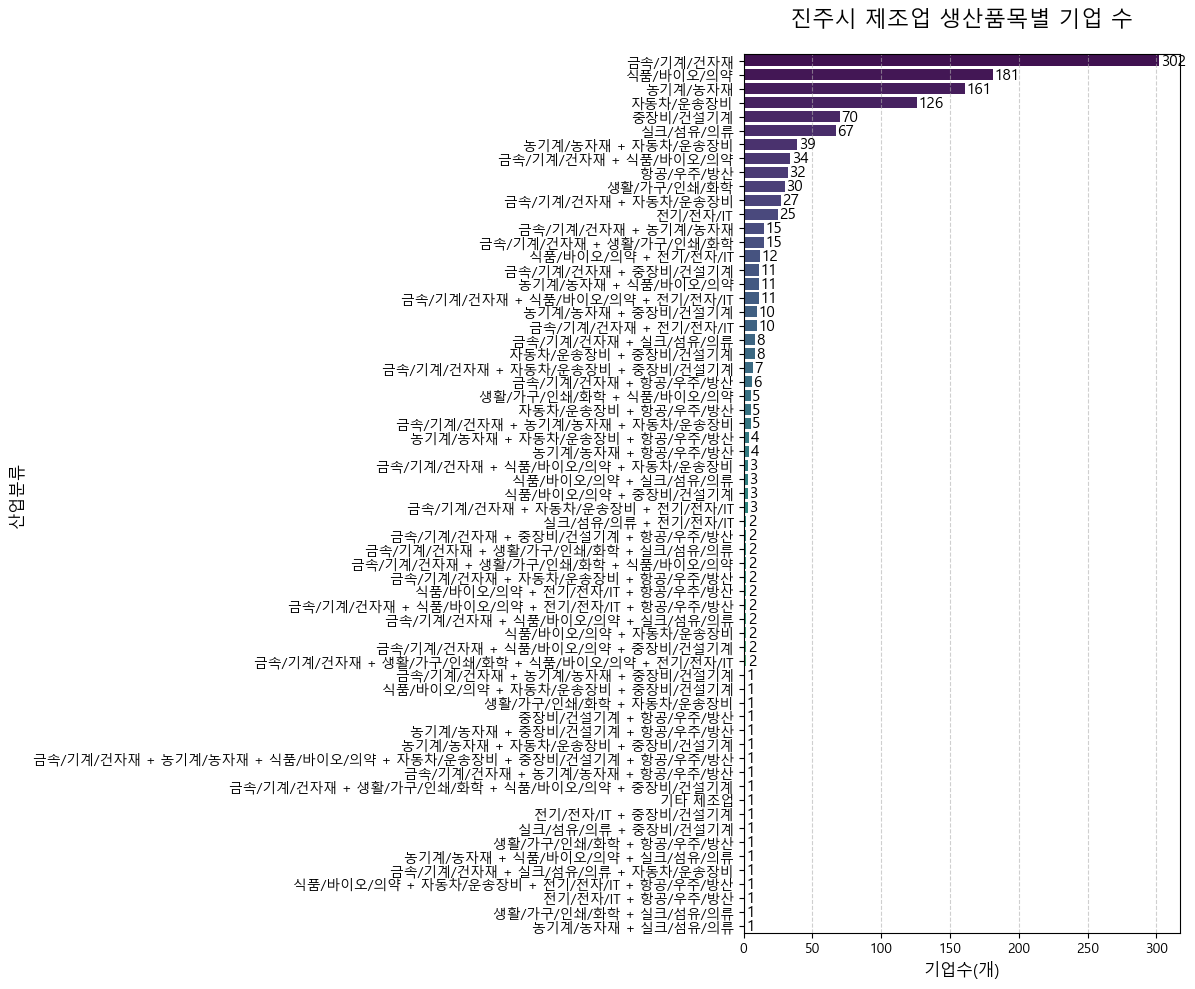

In [20]:
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

df_plot = df4['최종 생산품'].value_counts().reset_index()
df_plot.columns = ['생산품 분류', '기업수']

plt.figure(figsize=(12,10))
ax = sns.barplot(data=df_plot, y='생산품 분류', x='기업수', palette='viridis')

plt.title('진주시 제조업 생산품목별 기업 수', fontsize=16, pad=20)
plt.xlabel('기업수(개)', fontsize=12)
plt.ylabel('산업분류', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2, f'{int(width)}',
            ha = 'left', va = 'center', fontsize=11)

plt.tight_layout()
plt.show()

In [21]:
# df4 저장
df4.to_csv('진주시_생산품_분리.csv', index=False)